<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# NLP Walkthrough

_Authors: Riley Dallas (AUS)_

---


In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv('./datasets/sms.csv')
df.head()

,Unnamed: 0,class,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Load the data
---
This dataset (`'./datasets/SMSSpamCollection'`) is unique from other CSVs in two ways:
1. The columns are separated by tabs instead of commas
1. There isn't a header row

In [4]:
df= pd.read_csv('./datasets/SMSSpamCollection',sep='\t')
df.head() # our first obs was pulled in as he header row


,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [6]:
df= pd.read_csv('./datasets/SMSSpamCollection',sep='\t',names=['target','text'])
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data cleaning
---
In the cell below, binarize the target column. Spam is the positive class.

In [7]:
df['target'].replace({'ham':0, 'spam':1}, inplace=True)
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Create `X` and `y`
---

`CountVectorizer` requires a vector (`pd.Series`) as input, **not a matrix** (`pd.DataFrame`). 

In [8]:
X= df['text']
y= df['target']

## Baseline accuracy
---
In the cell below, calculate the baseline accuracy.

In [9]:
y.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: target, dtype: float64

If we were about to balance out the classes (using smote/oversample/undersample) then look at those distributions and those are typically are new baselines. 

When we work w/text we could duplicate our minority class before vectorizering our text. Could try to use LogisticRegression( class_weight = 'balanced')

## Train/Test split
---
We're assumming the dataset reflects the total population of emails. As such, we'll do a stratified split.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

In [31]:
# create a function to categorize spammy text phases into 1 column rather than a bunch of columns
def numbers_to_text(X):
    return X.str.replace('\b\d+\b','HAS_NUMBER',regex=True) # \word boundry \d any digit length \word boundryu\
    

In [32]:
from sklearn.preprocessing import FunctionTransformer # makes functions into a inputable parameter in a pipeline! 

In [33]:
number_to_text_tf  = FunctionTransformer(numbers_to_text, validate=False)

## Pipeline
---
Create a `Pipeline` object in the cell below with two stages:
1. `CountVectorizer`
1. A `LogisticRegression` model

In [34]:
pipe = Pipeline([
    ('number_to_text',number_to_text_tf),
    ('cvec', CountVectorizer()),
    ('model', LogisticRegression()),

])


## `GridSearchCV`
---
We've already grid searched on pipelines in previous lectures. This one is unique in that we'll focus on tuning the `CountVectorizer` instead of the model.

0.981095955970328
{'cvec__binary': True, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'model__C': 1.0}


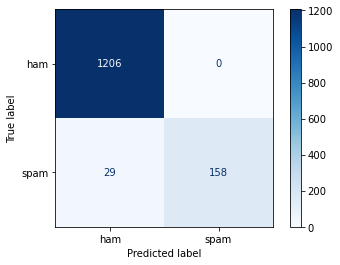

In [35]:
#(1,3) - potential overfitting, time consuming, more features 
hyper_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range':[(1,1), (1,3), (1,3)],
    'cvec__binary': [False, True],
    'model__C' : [1.0, 0.1, 0.001, 0.0001] # chose 1 the first time and then can maybe try higher magnitude values
}
gs = GridSearchCV(pipe, hyper_params,cv=3)
gs.fit(X_train,y_train)
print(gs.best_score_) # best cross validated score (defualt logistic regression - accuracy)
print(gs.best_params_)
plot_confusion_matrix(gs,X_test,y_test,cmap='Blues',display_labels=['ham','spam']); # display_labels[O_class,1_class]

0.981095955970328
{'cvec__binary': True, 'cvec__lowercase': True, 'cvec__max_df': 0.8, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'model__C': 1.0}


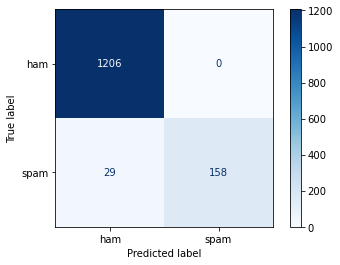

In [37]:
#(1,3) - potential overfitting, time consuming, more features 
hyper_params = {
    'cvec__stop_words': [None, 'english'], 
    'cvec__max_df':[0.8,0.7,0.65],
    'cvec__lowercase':[True,False],
    'cvec__ngram_range':[(1,1)],#preferring (1,1) 
    'cvec__binary': [False, True],
    'model__C' : [1.0, 0.1, 0.001, 0.0001] # chose 1 the first time and then can maybe try higher magnitude values
}
gs = GridSearchCV(pipe, hyper_params,cv=3)
gs.fit(X_train,y_train)
print(gs.best_score_) # best cross validated score (defualt logistic regression - accuracy)
print(gs.best_params_)
plot_confusion_matrix(gs,X_test,y_test,cmap='Blues',display_labels=['ham','spam']); # display_labels[O_class,1_class]

0.9830102895429529
{'cvec__binary': True, 'cvec__lowercase': True, 'cvec__max_df': 0.8, 'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'model__C': 100}


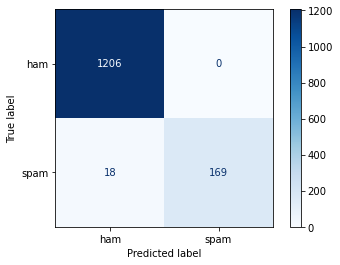

In [39]:
#(1,3) - potential overfitting, time consuming, more features 
hyper_params = {
    'cvec__stop_words': [None, 'english'], 
    'cvec__max_df':[0.8,0.7,0.65],
    'cvec__max_features':[2000,3000,4000],
    'cvec__lowercase':[True,False],
    'cvec__ngram_range':[(1,1)],#preferring (1,1) 
    'cvec__binary': [False, True],
    'model__C' : [10,100] # chose 1 the first time and then can maybe try higher magnitude values
}
gs = GridSearchCV(pipe, hyper_params,cv=3)
gs.fit(X_train,y_train)
print(gs.best_score_) # best cross validated score (defualt logistic regression - accuracy)
print(gs.best_params_)
plot_confusion_matrix(gs,X_test,y_test,cmap='Blues',display_labels=['ham','spam']); # display_labels[O_class,1_class]

0.9830102895429529
{'cvec__binary': True, 'cvec__lowercase': True, 'cvec__max_df': 0.8, 'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'model__C': 100}


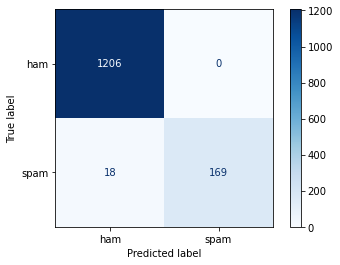

In [40]:
#(1,3) - potential overfitting, time consuming, more features 
hyper_params = {
    'cvec__stop_words': [None, 'english'], 
    'cvec__max_df':[0.8,0.7], # likes the max_df so removing 
    'cvec__max_features':[1500,2000,2500],
    'cvec__lowercase':[True,False],
    'cvec__ngram_range':[(1,1)],#preferring (1,1) 
    'cvec__binary': [True],
    'model__C' : [10,100] # chose 1 the first time and then can maybe try higher magnitude values
}
gs = GridSearchCV(pipe, hyper_params,cv=3)
gs.fit(X_train,y_train)
print(gs.best_score_) # best cross validated score (defualt logistic regression - accuracy)
print(gs.best_params_)
plot_confusion_matrix(gs,X_test,y_test,cmap='Blues',display_labels=['ham','spam']); # display_labels[O_class,1_class]

this is now accuracy 0.8982519694094647
{'cvec__binary': True, 'cvec__lowercase': True, 'cvec__max_df': 0.8, 'cvec__max_features': 2000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'model__C': 100}


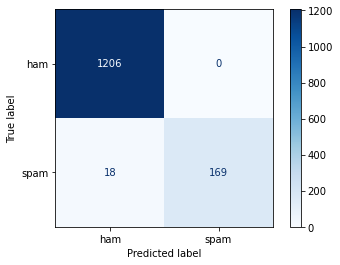

In [44]:
#(1,3) - potential overfitting, time consuming, more features 
hyper_params = {
    'cvec__stop_words': [None, 'english'], 
    'cvec__max_df':[0.8,0.7], # likes the max_df so removing 
    'cvec__max_features':[1500,2000,2500],
    'cvec__lowercase':[True,False],
    'cvec__ngram_range':[(1,1)],#preferring (1,1) 
    'cvec__binary': [True],
    'model__C' : [10,100] # chose 1 the first time and then can maybe try higher magnitude values
}
gs = GridSearchCV(pipe, hyper_params,scoring='recall',cv=3)
gs.fit(X_train,y_train)
print('this is now accuracy',gs.best_score_) # best cross validated score (defualt logistic regression - accuracy)
print(gs.best_params_)
plot_confusion_matrix(gs,X_test,y_test,cmap='Blues',display_labels=['ham','spam']); # display_labels[O_class,1_class]

## Model Evaluation
---
Plot a confusion matrix in the cell below.

In [17]:
 # filtering to1 look at where we are wrong
preds = gs.predict(X_test)
mask = (y_test!=preds)&(preds==0)
X_test[mask]

3360    Sorry I missed your call let's talk when you h...
1217    You have 1 new voicemail. Please call 08719181...
751     Do you realize that in about 40 years, we'll h...
2823    ROMCAPspam Everyone around should be respondin...
4473      3. You have received your mobile content. Enjoy
607     XCLUSIVE@CLUBSAISAI 2MOROW 28/5 SOIREE SPECIAL...
2352    Download as many ringtones as u like no restri...
1274    network operator. The service is free. For T &...
1460    Bought one ringtone and now getting texts cost...
2804                    FreeMsg>FAV XMAS TONES!Reply REAL
761     Romantic Paris. 2 nights, 2 flights from £79 B...
3981                                   ringtoneking 84484
2247    Hi ya babe x u 4goten bout me?' scammers getti...
4506    Mobile Club: Choose any of the top quality ite...
1940    More people are dogging in your area now. Call...
2863    Adult 18 Content Your video will be with you s...
1269    Can U get 2 phone NOW? I wanna chat 2 set up m...
5540    ASKED 